In [12]:
from models import  vae_hyp_celeba, vae_EUCL
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
from hypmath import metrics
import pandas as pd 
from tqdm import tqdm
import time
from torch.utils.data import SubsetRandomSampler

#Disable Debugging APIs
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

#cuDNN Autotuner
torch.backends.cudnn.benchmark = True

#CUDA check

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
image_size = 64
transform = transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.CenterCrop(image_size),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ])


trainset = datasets.ImageFolder('data', transform=transform)
num_data = list(range(0, 102400))
trainset_1 = torch.utils.data.Subset(trainset, num_data)
size= len(trainset)
train_data, val_data = torch.utils.data.random_split(trainset, [int(size-size*0.2), int(size*0.2)])
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, 
                                         num_workers=1, pin_memory=True, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
# dataiter = iter(trainloader)
# images, _ = dataiter.next()
# images.shape

ValueError: Sum of input lengths does not equal the length of the input dataset!

In [ ]:
### Training function

reconstruction_function = nn.MSELoss(reduction='sum')
#reconstruction_function.size_average = False
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # https://arxiv.org/abs/1312.6114 (Appendix B)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        for param in vae.parameters():
            param.grad = None

        recon_x, mu, logvar = vae(x)
        # Evaluate loss
        #loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)
        #loss = BCE + (vae.encoder.kl)
        loss = loss_function(recon_x, x, mu, logvar)

        # Backward pass
        #optimizer.zero_grad()   
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [ ]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            recon_x, mu, logvar = vae(x)
            # Evaluate loss
            #loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)
            #loss = BCE + (vae.encoder.kl)
            loss = loss_function(recon_x, x, mu, logvar)
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [ ]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = trainset_1[i][0].unsqueeze(0)
      img = img.to(device)
      #img = next(iter(trainloader))
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
        z, _ , _ = encoder(img)
        rec_img  = decoder(z)
      plt.imshow(img.cpu().squeeze().permute(1, 2, 0).numpy())
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow((rec_img.cpu().squeeze().permute(1, 2, 0).numpy()))  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


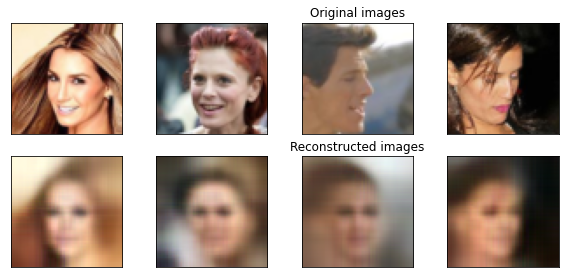

	 partial train loss (single batch): 17422.320312
	 partial train loss (single batch): 16322.670898
	 partial train loss (single batch): 18531.437500
	 partial train loss (single batch): 18011.462891
	 partial train loss (single batch): 16676.828125
	 partial train loss (single batch): 16564.392578
	 partial train loss (single batch): 18597.453125
	 partial train loss (single batch): 16532.373047
	 partial train loss (single batch): 17555.433594
	 partial train loss (single batch): 17141.925781
	 partial train loss (single batch): 16815.000000
	 partial train loss (single batch): 17041.396484
	 partial train loss (single batch): 17700.292969
	 partial train loss (single batch): 16264.915039
	 partial train loss (single batch): 17042.507812
	 partial train loss (single batch): 17520.144531
	 partial train loss (single batch): 16784.218750
	 partial train loss (single batch): 15947.669922
	 partial train loss (single batch): 16689.744141
	 partial train loss (single batch): 16879.492188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 2/10 	 train loss 247.726 	 validation loss 233.627


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


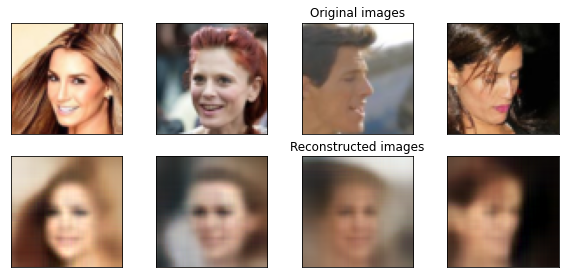

	 partial train loss (single batch): 15306.729492
	 partial train loss (single batch): 16179.027344
	 partial train loss (single batch): 15931.791992
	 partial train loss (single batch): 15513.294922
	 partial train loss (single batch): 15982.669922
	 partial train loss (single batch): 15663.379883
	 partial train loss (single batch): 16742.306641
	 partial train loss (single batch): 14820.851562
	 partial train loss (single batch): 14699.094727
	 partial train loss (single batch): 14233.297852
	 partial train loss (single batch): 15381.115234
	 partial train loss (single batch): 15507.736328
	 partial train loss (single batch): 19964.591797
	 partial train loss (single batch): 15110.763672
	 partial train loss (single batch): 15414.322266
	 partial train loss (single batch): 16299.752930
	 partial train loss (single batch): 15194.924805
	 partial train loss (single batch): 15015.214844
	 partial train loss (single batch): 15290.793945
	 partial train loss (single batch): 15322.516602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 3/10 	 train loss 229.743 	 validation loss 231.413


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


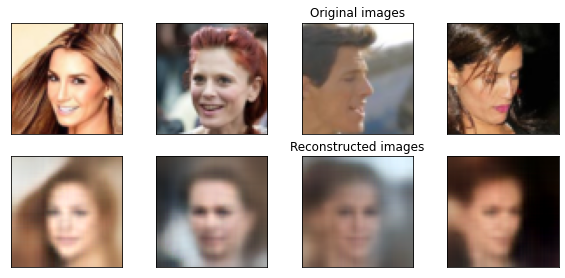

	 partial train loss (single batch): 14647.936523
	 partial train loss (single batch): 14455.304688
	 partial train loss (single batch): 13827.181641
	 partial train loss (single batch): 14673.189453
	 partial train loss (single batch): 14873.771484
	 partial train loss (single batch): 13278.556641
	 partial train loss (single batch): 13794.052734
	 partial train loss (single batch): 14509.025391
	 partial train loss (single batch): 13081.797852
	 partial train loss (single batch): 14652.164062
	 partial train loss (single batch): 14053.371094
	 partial train loss (single batch): 13826.076172
	 partial train loss (single batch): 13508.556641
	 partial train loss (single batch): 14002.546875
	 partial train loss (single batch): 14159.248047
	 partial train loss (single batch): 13964.681641
	 partial train loss (single batch): 14242.041016
	 partial train loss (single batch): 13860.759766
	 partial train loss (single batch): 13999.845703
	 partial train loss (single batch): 14185.617188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 4/10 	 train loss 219.615 	 validation loss 210.037


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


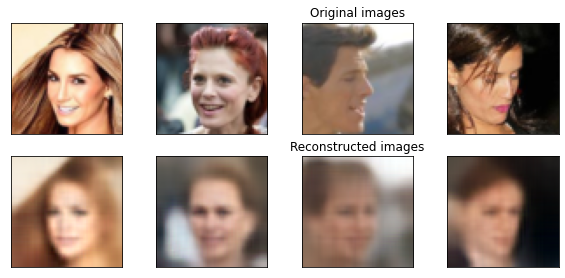

	 partial train loss (single batch): 13968.908203
	 partial train loss (single batch): 14947.400391
	 partial train loss (single batch): 14365.803711
	 partial train loss (single batch): 13260.300781
	 partial train loss (single batch): 13985.865234
	 partial train loss (single batch): 15804.132812
	 partial train loss (single batch): 14650.384766
	 partial train loss (single batch): 14841.253906
	 partial train loss (single batch): 13833.259766
	 partial train loss (single batch): 14090.376953
	 partial train loss (single batch): 13039.349609
	 partial train loss (single batch): 12936.350586
	 partial train loss (single batch): 13524.626953
	 partial train loss (single batch): 13742.899414
	 partial train loss (single batch): 13776.181641
	 partial train loss (single batch): 13591.157227
	 partial train loss (single batch): 14084.892578
	 partial train loss (single batch): 14591.441406
	 partial train loss (single batch): 13100.052734
	 partial train loss (single batch): 13496.185547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 5/10 	 train loss 212.561 	 validation loss 206.353


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


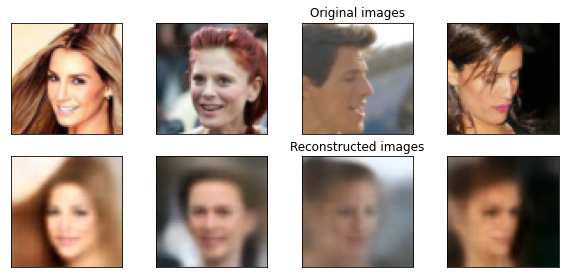

	 partial train loss (single batch): 12550.791992
	 partial train loss (single batch): 12579.225586
	 partial train loss (single batch): 13309.971680
	 partial train loss (single batch): 13671.821289
	 partial train loss (single batch): 14611.884766
	 partial train loss (single batch): 12988.687500
	 partial train loss (single batch): 12715.749023
	 partial train loss (single batch): 12528.500000
	 partial train loss (single batch): 13336.681641
	 partial train loss (single batch): 13526.586914
	 partial train loss (single batch): 13114.097656
	 partial train loss (single batch): 13215.833984
	 partial train loss (single batch): 13108.492188
	 partial train loss (single batch): 14010.949219
	 partial train loss (single batch): 13174.568359
	 partial train loss (single batch): 12972.654297
	 partial train loss (single batch): 13224.046875
	 partial train loss (single batch): 13870.250000
	 partial train loss (single batch): 13004.199219
	 partial train loss (single batch): 13614.111328


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 6/10 	 train loss 207.357 	 validation loss 205.447


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


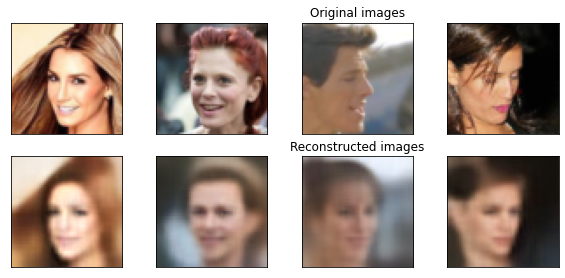

	 partial train loss (single batch): 13006.532227
	 partial train loss (single batch): 15787.985352
	 partial train loss (single batch): 12490.159180
	 partial train loss (single batch): 13222.206055
	 partial train loss (single batch): 13078.126953
	 partial train loss (single batch): 12214.104492
	 partial train loss (single batch): 14115.318359
	 partial train loss (single batch): 12826.164062
	 partial train loss (single batch): 12858.576172
	 partial train loss (single batch): 13487.171875
	 partial train loss (single batch): 12407.703125
	 partial train loss (single batch): 12948.794922
	 partial train loss (single batch): 12497.904297
	 partial train loss (single batch): 12921.876953
	 partial train loss (single batch): 14087.274414
	 partial train loss (single batch): 13469.884766
	 partial train loss (single batch): 13236.537109
	 partial train loss (single batch): 13373.472656
	 partial train loss (single batch): 11512.808594
	 partial train loss (single batch): 12578.955078


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 7/10 	 train loss 202.897 	 validation loss 198.132


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


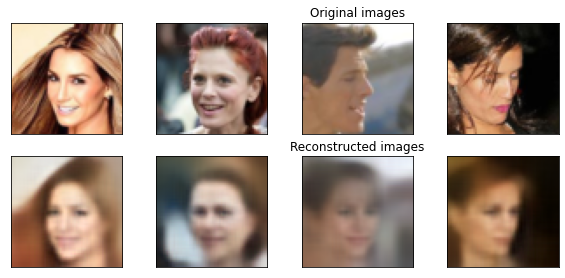

	 partial train loss (single batch): 13108.780273
	 partial train loss (single batch): 12273.811523
	 partial train loss (single batch): 12292.517578
	 partial train loss (single batch): 12865.832031
	 partial train loss (single batch): 13175.095703
	 partial train loss (single batch): 12478.825195
	 partial train loss (single batch): 13174.792969
	 partial train loss (single batch): 12787.349609
	 partial train loss (single batch): 12663.884766
	 partial train loss (single batch): 12578.490234
	 partial train loss (single batch): 12600.458984
	 partial train loss (single batch): 12251.298828
	 partial train loss (single batch): 13226.917969
	 partial train loss (single batch): 13132.841797
	 partial train loss (single batch): 13025.440430
	 partial train loss (single batch): 13049.015625
	 partial train loss (single batch): 12951.667969
	 partial train loss (single batch): 13865.986328
	 partial train loss (single batch): 12131.045898
	 partial train loss (single batch): 13259.547852


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 8/10 	 train loss 199.754 	 validation loss 194.840


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


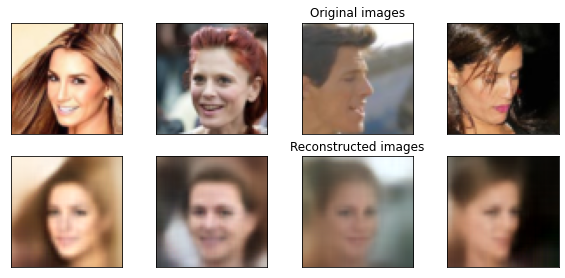

	 partial train loss (single batch): 12544.479492
	 partial train loss (single batch): 12311.494141
	 partial train loss (single batch): 12797.923828
	 partial train loss (single batch): 11778.004883
	 partial train loss (single batch): 13104.100586
	 partial train loss (single batch): 11641.380859
	 partial train loss (single batch): 12447.292969
	 partial train loss (single batch): 12451.334961
	 partial train loss (single batch): 12922.544922
	 partial train loss (single batch): 12320.188477
	 partial train loss (single batch): 12896.996094
	 partial train loss (single batch): 12524.882812
	 partial train loss (single batch): 13168.083984
	 partial train loss (single batch): 12246.355469
	 partial train loss (single batch): 12505.227539
	 partial train loss (single batch): 12778.566406
	 partial train loss (single batch): 12519.737305
	 partial train loss (single batch): 13028.779297
	 partial train loss (single batch): 12854.583008
	 partial train loss (single batch): 12363.710938


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 9/10 	 train loss 196.242 	 validation loss 196.408


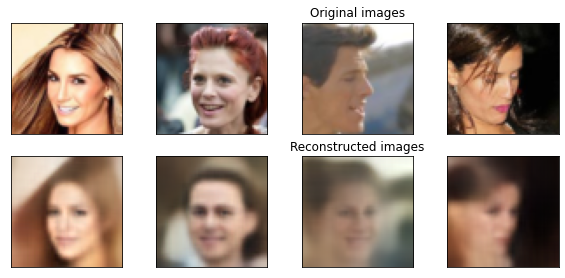

	 partial train loss (single batch): 12245.124023
	 partial train loss (single batch): 12207.445312
	 partial train loss (single batch): 12394.772461
	 partial train loss (single batch): 11467.824219
	 partial train loss (single batch): 12528.259766
	 partial train loss (single batch): 13125.958984
	 partial train loss (single batch): 11658.005859
	 partial train loss (single batch): 12371.697266
	 partial train loss (single batch): 12012.720703
	 partial train loss (single batch): 11215.445312
	 partial train loss (single batch): 12617.849609
	 partial train loss (single batch): 13157.621094
	 partial train loss (single batch): 12266.101562
	 partial train loss (single batch): 12530.255859
	 partial train loss (single batch): 12822.261719
	 partial train loss (single batch): 12676.813477
	 partial train loss (single batch): 12484.176758
	 partial train loss (single batch): 12916.550781
	 partial train loss (single batch): 12566.072266
	 partial train loss (single batch): 12492.708984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 10/10 	 train loss 193.935 	 validation loss 189.843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


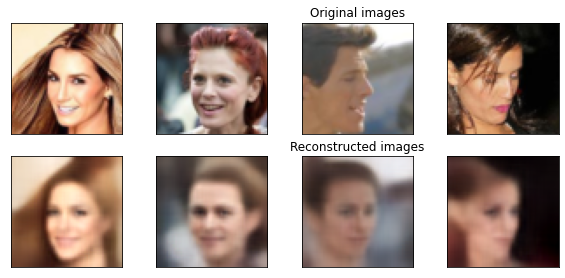

In [ ]:
model = vae_EUCL.VariationalAutoencoder(nc=3, ndf=64, ngf=64, latent_dims=500, device=device)
#model = vae_hyp_celeba.VariationalAutoencoder(nc=3, ndf=64, ngf=64, latent_dims=500, device=device)
model.to(device)
print(model)
epochs = 5
lr = 5e-4
#lr = 0.01

#optimizer = geoopt.optim.RiemannianAdam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
t_loss = []
v_loss = []
epoch_values =[]
#Training loop
for epoch in range(epochs):
   train_loss = train_epoch(model, trainloader, optimizer)
   val_loss = test_epoch(model, valloader)
   t_loss.append(train_loss)
   v_loss.append(val_loss)
   epoch_values.append(epoch)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t validation loss {:.3f}'.format(epoch + 1, epochs, train_loss, val_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=4)


# save model checkpoint
# torch.save({
#             'epoch': epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss_function,
#             }, 'outputs/resnet_model.pth')

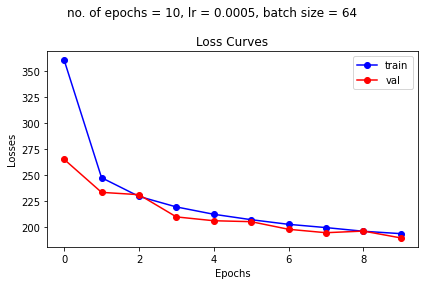

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig , (ax0) = plt.subplots(1, 1)

# ax0 = fig.add_subplot(121, title="Loss curves")
# ax1 = fig.add_subplot(122, title="Accuracy curves")
ax0.set_title('Loss Curves')
ax0.plot(epoch_values, t_loss, 'bo-', label='train')
ax0.plot(epoch_values, v_loss, 'ro-', label='val')


#start, end = ax1.get_ylim()
# ax1.yaxis.set_ticks(np.arange(0.7, 1.0, 0.02))
# ax1.set_ylim(0.7, 1.0)
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax0.set_xlabel('Epochs')
ax0.set_ylabel('Losses')
ax0.legend()

fig.suptitle('no. of epochs = {}, lr = {}, batch size = 64'.format(epochs, lr))
fig.tight_layout()

#Resuming Model Training

In [ ]:
# # load the trained model
# model_resume = model.to(device) # initilize the model
# # initialize optimizer  before loading optimizer state_dict
# epochs_new = 5
# learning_rate_new = 5e-4
# optimizer_new = optim.Adam(model_resume.parameters(), lr=learning_rate_new)


# checkpoint = torch.load('outputs/model.pth')

# # load model weights state_dict
# model.load_state_dict(checkpoint['model_state_dict'])
# print('Previously trained model weights state_dict loaded...')

# # load trained optimizer state_dict
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# print('Previously trained optimizer state_dict loaded...')

# epochs = checkpoint['epoch']
# # load the criterion
# loss_function = checkpoint['loss']
# print('Trained model loss function loaded...')
# print(f"Previously trained for {epochs} number of epochs...")

# # train for more epochs
# epochs = epochs_new
# print(f"Train for {epochs} more epochs...")


# #New Training loop
# for epoch in range(epochs):
#    train_loss = train_epoch(model_resume, trainloader, optimizer_new)
#    print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, epochs, train_loss))
#    plot_ae_outputs(model.encoder, model.decoder,n=4)

# # save model checkpoint
# torch.save({
#             'epoch': epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss_function,
#             }, 'outputs/model.pth')

#5,3,3,3,5

In [ ]:
# encoded_samples = []
# for sample in tqdm(trainset_1):
#     img = sample[0].unsqueeze(0)
#     label = sample[1]
#     # Encode image
#     model.eval()
#     with torch.no_grad():
#         encoded_img  = model.encoder(img)
#     # Append to list
#     encoded_img = encoded_img.flatten().cpu().numpy()
#     encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
#     encoded_sample['label'] = label
#     encoded_samples.append(encoded_sample)
    
# encoded_samples = pd.DataFrame(encoded_samples)



# from sklearn.manifold import TSNE
# from sklearn.metrics import davies_bouldin_score
# from sklearn.metrics import calinski_harabasz_score
# from sklearn.metrics import silhouette_score
# import plotly.express as px

# #Davies-Bouldin Index
# db_index = davies_bouldin_score(encoded_samples, encoded_samples.label)
# print(db_index)

# #Calinski-Harabasz Index
# ch_score = calinski_harabasz_score(encoded_samples, encoded_samples.label)
# print(ch_score)

# # #Silhouette Coefficient
# # s_coeff = silhouette_score(encoded_samples, encoded_samples.label,  metric=metrics.PoincareDistance)
# # print(s_coeff)

# px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

# fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})

# # #Davies-Bouldin Index
# # db_index = davies_bouldin_score(tsne_results, encoded_samples.label)
# # print(db_index)

# # #Calinski-Harabasz Index
# # ch_score = calinski_harabasz_score(tsne_results, encoded_samples.label)
# # print(ch_score)

# # #Silhouette Coefficient
# # s_coeff = silhouette_score(tsne_results, encoded_samples.label)
# # print(s_coeff)
# fig.show()